In [ ]:
!pip install pandas openpyxl sentence-transformers hdbscan keybert umap-learn matplotlib seaborn

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from keybert import KeyBERT
import hdbscan
import pandas as pd
import numpy as np

In [ ]:
#get the data
excel_path = "output_file.xlsx"
text_column = "Remarks"

# Read Excel
df1 = pd.read_excel(excel_path)

# Clean up: Fill missing or blank values
df1[text_column] = df1[text_column].replace(r'^\s*$', "None", regex=True).fillna("None")

In [ ]:
df1.head()

,Model,State,Application,Remarks,Status,Enquiry Source
0,Model 13,Maharashtra,Road Construction,in follow up,Closed,Field Visit /Cold Calling
1,Model 1,Andhra Pradesh,Agriculture,no need any vehicle,Closed,Field Visit /Cold Calling
2,Model 32,Tamil Nadu,Coal & ores,f/up,Closed,Field Visit /Cold Calling
3,Model 3,Tamil Nadu,Parcel,after bs6 planning,Closed,Field Visit /Cold Calling
4,Model 9,Andhra Pradesh,Food chain,contact on next month,Closed,Field Visit /Cold Calling


In [ ]:
#To send only required code- output variable required is docs

Status= input("Enter Status:")
df=df1[df1["Status"]==Status]

#Model= 'Model '+ str(input("Enter Model No.:"))
#fdf=df[df["Model"]==Model]

State=input("Enter State:")
df=df[df["State"]==State]

#To get all the text
docs = df[text_column].astype(str).tolist()

Enter Status:Lost
Enter State:Gujarat


In [ ]:
df.value_counts().to_excel("value_counts.xlsx")

In [ ]:
# Step 1: Generate embeddings using Sentence-BERT
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(docs)

In [ ]:
# Step 2: Cluster using HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean',min_samples=1)
cluster_labels = clusterer.fit_predict(embeddings)

In [ ]:
# Step 3: Assign cluster labels to docs
df = pd.DataFrame({'text': docs})
df['cluster'] = cluster_labels

In [ ]:
# Step 4: Extract keywords per cluster using KeyBERT
kw_model = KeyBERT(model=model)

print("\n=== Keywords per Cluster ===")
for cluster_num in sorted(df['cluster'].unique()):
    if cluster_num == -1:
        continue  # Skip noise/outliers
    cluster_texts = df[df['cluster'] == cluster_num]['text'].tolist()
    joined_text = " ".join(cluster_texts)
    keywords = kw_model.extract_keywords(joined_text, top_n=5)
    keyword_list = [kw for kw, _ in keywords]
    print(f"\nCluster {cluster_num}: {', '.join(keyword_list)}")
    for i, review in enumerate(cluster_texts, 1):
        print(f"  {i}. {review}")


=== Keywords per Cluster ===

Cluster 0: 
  1. 0
  2. 0
  3. 0
  4. 0
  5. 0
  6. 0
  7. 0
  8. 0
  9. 0
  10. 0
  11. 0

Cluster 1: tanker, tyres, 14wheels, 24ft, varient
  1. we don't have 24ft varient in 12 Tyres truck,  varient difference
  2. we don't have tanker varient in 14wheels truck
  3. use in OXYGEN TANKER BODY
  4. Tanker Application
  5. Tanker Application
  6. Tanker Application
  7. TANKER APPLICATION
  8. TANKER APPLICATION
  9. Tanker Application
  10. TANKER APPLICATION
  11. Tanker Application
  12. Chemical Tanker Application
  13. Tanker Application
  14. Tanker Application
  15. Tanker Application
  16. Tanker Application
  17. Tanker Application
  18. BPCL PETROLEUM TANKER APPLICATION, delivery within 2 Day's
  19. BPCL PETROLEUM TANKER APPLICATION
  20. TANKER APPLICATION,

Cluster 2: customer, eicher, purchases, market, loyal
  1. customer want to buy only eicher, due to happy and existing customer not preferred to go any other brand.
  2. customer purchases

In [ ]:
pip install umap-learn matplotlib


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


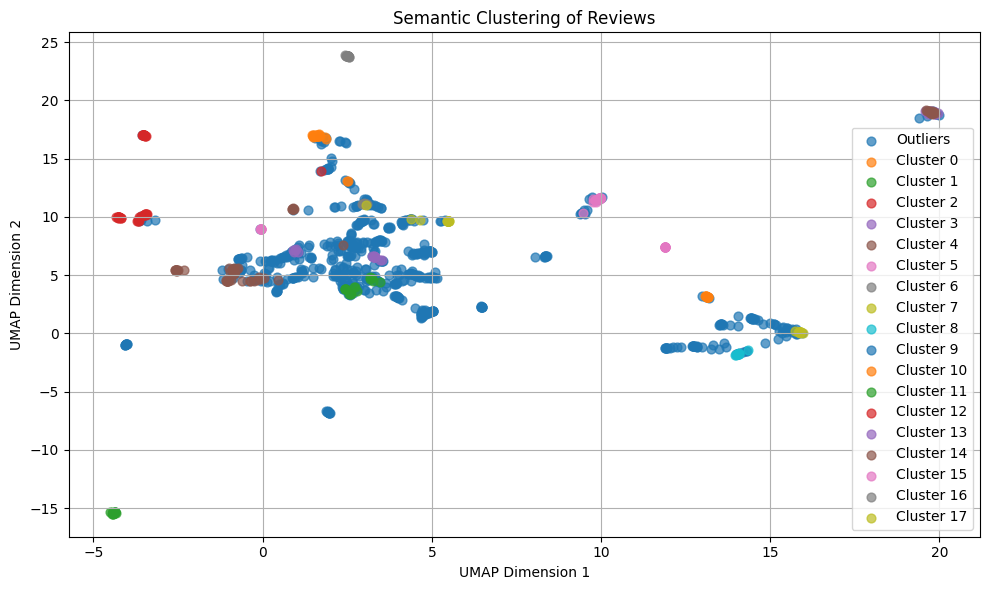

In [ ]:
import matplotlib.pyplot as plt
import umap
import numpy as np

# Step 1: Reduce embeddings to 2D
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# Step 2: Plot with colors per cluster
plt.figure(figsize=(10, 6))

# Create color map per cluster
unique_clusters = np.unique(cluster_labels)
for cluster in unique_clusters:
    mask = cluster_labels == cluster
    label = f"Cluster {cluster}" if cluster != -1 else "Outliers"
    plt.scatter(
        embedding_2d[mask, 0],
        embedding_2d[mask, 1],
        label=label,
        s=40,
        alpha=0.7
    )

plt.title("Semantic Clustering of Reviews")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


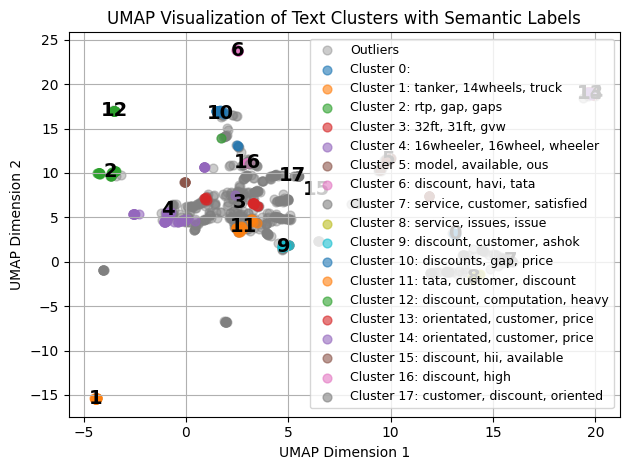

In [ ]:
import matplotlib.pyplot as plt
import umap
import numpy as np
import pandas as pd
from keybert import KeyBERT

# === UMAP reduction ===
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# === Create DataFrame with everything ===
df_plot = pd.DataFrame({
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'cluster': cluster_labels,
    'text': docs
})

# === Extract semantic labels for each cluster ===
kw_model = KeyBERT(model)
semantic_labels = {}

for cluster in sorted(df_plot['cluster'].unique()):
    if cluster == -1:
        continue  # Skip noise
    texts = df_plot[df_plot['cluster'] == cluster]['text'].tolist()
    joined = " ".join(texts)
    keywords = kw_model.extract_keywords(joined, top_n=3)
    label = ", ".join([kw for kw, _ in keywords])
    semantic_labels[cluster] = label

# === Plot with semantic labels ===
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(cluster_labels)

for cluster in unique_clusters:
    cluster_data = df_plot[df_plot['cluster'] == cluster]

    if cluster == -1:
        plt.scatter(cluster_data['x'], cluster_data['y'], label="Outliers", s=40, alpha=0.4, c="gray")
        continue

    # Plot points
    plt.scatter(cluster_data['x'], cluster_data['y'], s=40, alpha=0.6, label=f"Cluster {cluster}: {semantic_labels[cluster]}")

    # Add label at cluster centroid
    centroid_x = cluster_data['x'].mean()
    centroid_y = cluster_data['y'].mean()
    plt.text(centroid_x, centroid_y, str(cluster), fontsize=14, weight='bold', ha='center', va='center')

# Final touches
plt.title("UMAP Visualization of Text Clusters with Semantic Labels")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(loc='best', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


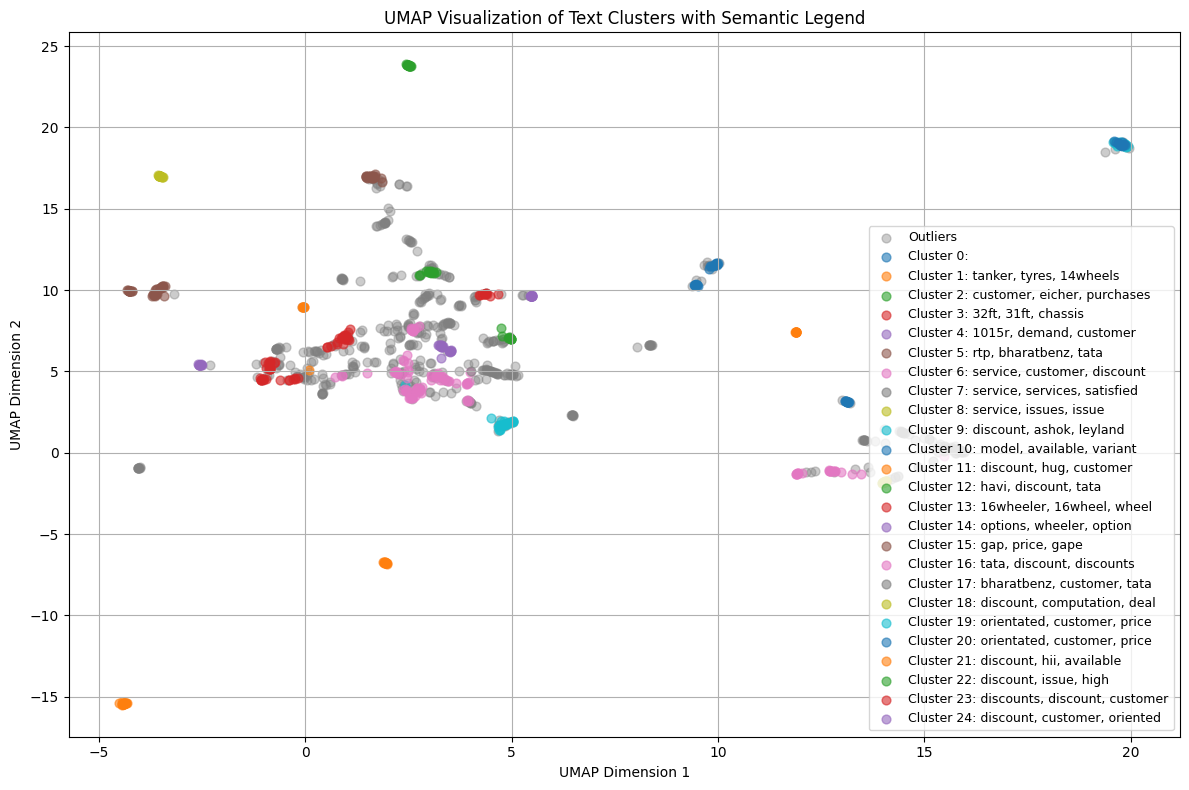

In [ ]:
import matplotlib.pyplot as plt
import umap
import numpy as np
import pandas as pd
from keybert import KeyBERT

# === UMAP reduction ===
reducer = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine', random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# === Create DataFrame ===
df_plot = pd.DataFrame({
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'cluster': cluster_labels,
    'text': docs
})

# === Extract semantic labels ===
kw_model = KeyBERT(model)
semantic_labels = {}

for cluster in sorted(df_plot['cluster'].unique()):
    if cluster == -1:
        continue
    texts = df_plot[df_plot['cluster'] == cluster]['text'].tolist()
    joined = " ".join(texts)
    keywords = kw_model.extract_keywords(joined, top_n=3)
    label = ", ".join([kw for kw, _ in keywords])
    semantic_labels[cluster] = label

# === Plot without internal text labels ===
plt.figure(figsize=(12, 8))
unique_clusters = np.unique(cluster_labels)

for cluster in unique_clusters:
    cluster_data = df_plot[df_plot['cluster'] == cluster]

    if cluster == -1:
        plt.scatter(cluster_data['x'], cluster_data['y'], label="Outliers", s=40, alpha=0.4, c="gray")
        continue

    plt.scatter(
        cluster_data['x'], cluster_data['y'],
        s=40, alpha=0.6,
        label=f"Cluster {cluster}: {semantic_labels[cluster]}"
    )

# Final touches
plt.title("UMAP Visualization of Text Clusters with Semantic Legend")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(loc='best', fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()
